# Heralded Preparation of Fock States

Author: Nicolás Quesada 

In this tutorial we study how to prepare the $n=2$ Fock state by heralding a two-mode squeezed vacuum state using photon-number-resolving detectors.
The idea of preparing Fock states by heralding goes back to at least the following paper:
"Experimental realization of a localized one-photon state" [Phys. Rev. Lett. 56, 58 (1986)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.56.58) by C. K. Hong and L. Mandel.

In [ ]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing to use. We pick the squeezing parameter to be $r = \text{arcsinh}\left(\sqrt{n}\right)$ so that the mean photon number in each of the modes is precisely $\bar{n} = \sinh^2 r = n$. This will maximize the probability of generating the given Fock state with $n$ photons. Note that we could pick a different value of $n$.

In [2]:
n = 2
r = np.arcsinh(np.sqrt(n))

Now we setup a 2-mode quantum circuit in strawberryfields and obtain the covariance matrix and vector of means of the Gaussian state.

In [3]:
nmodes = 2
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    S2gate(r)|q
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

In [4]:
# Here we use the sf circuit drawer and standard linux utilities 
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "fock_circuit.svg"
!pdflatex  $file > /dev/null 2>&1
!pdfcrop $filepdf > /dev/null 2>&1
!pdf2svg $filecrop $name

Here is a graphical representation of the circuit. It is always assumed that the input is vacuum in all the modes. <br>
![img](./fock_circuit.svg)

We can now inspect the covariance matrix and vector of means. Note that the vector of means is zero since we did not use any displacement gates in the circuit above.

In [5]:
print(np.round(mu,10))
print(np.round(cov,10))

[0. 0. 0. 0.]
[[ 5.          4.89897949  0.         -0.        ]
 [ 4.89897949  5.         -0.          0.        ]
 [ 0.         -0.          5.         -4.89897949]
 [-0.          0.         -4.89897949  5.        ]]


We now use the walrus to obtain the Fock representation of the heralded Gaussian state when mode 1 is heralded in the value $n=1$ in the variable `psi`. We also calculate the probability of success in heralding in the variable `p_psi`.

In [6]:
cutoff = 10
psi = state_vector(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,5))

The probability of successful heralding is  0.14815


We now plot the photon-number distribution of the heralded state. Note that the state is exactly a Fock state with a two photons.

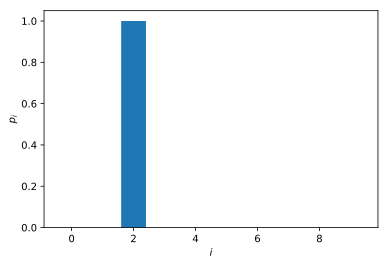

In [7]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
plt.show()

We can now plot the Wigner function of the heralded state,

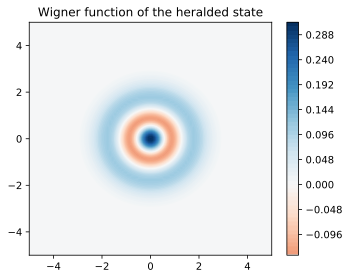

In [8]:
grid = 100
xvec = np.linspace(-5,5,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $x=0$.

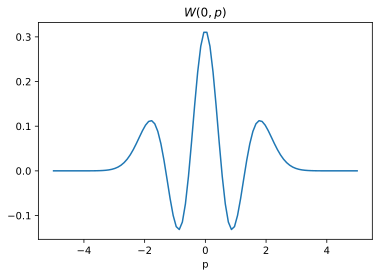

In [9]:
plt.plot(xvec, Wp[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")
plt.show()

## Adding Loss

We can now study what happens when loss in the heralding arm is increased. We will add loss in the heralding arm by varying the efficiency of the detector which is parametrized by a transmission $\eta$ ranging from $\eta = 50\%$ to $\eta = 100\%$ (ideal operation).

In [10]:
eta_vals = np.arange(1.,0.45,-0.05)
fidelities = np.zeros_like(eta_vals)
success_p = np.zeros_like(eta_vals)
nmodes = 2
for i,eta in enumerate(eta_vals):
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")
    with prog.context as q:
        S2gate(r)|q
        LossChannel(eta)|q[1]
    state = eng.run(prog).state
    mu = state.means()
    cov = state.cov()
    rho = density_matrix(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
    success_p[i] = np.real_if_close(np.trace(rho))
    fidelities[i] = np.real_if_close(psi.conj() @ rho @ psi/success_p[i])

We now plot the probability of success of the heralding scheme as a function of the transmission,

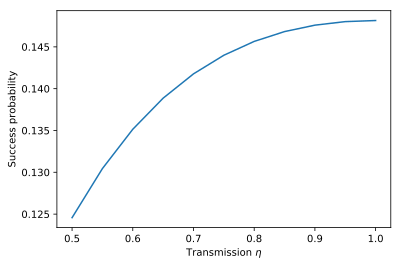

In [11]:
plt.plot(eta_vals, success_p)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Success probability")
plt.show()

and similarly study the fidelity of the heralded state with respect to the ideal (lossless) state.

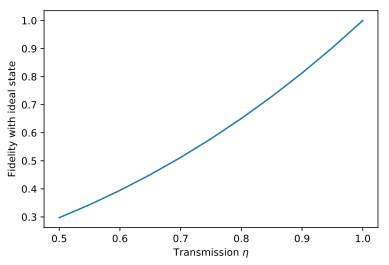

In [12]:
plt.plot(eta_vals, fidelities)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Fidelity with ideal state")
plt.show()

We can also look at the photon number distribution of the nonideal state. Notice that it has components along many different Fock states with n>2

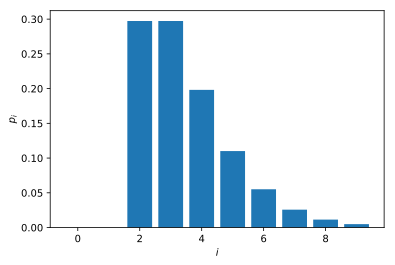

In [13]:
plt.bar(np.arange(cutoff),np.real_if_close(np.diag(rho/np.trace(rho))))
plt.xlabel(r"$i$")
plt.ylabel(r"$p_i$")
plt.show()

Now we plot the Wigner function of the heralded state for $\eta = 50\%$

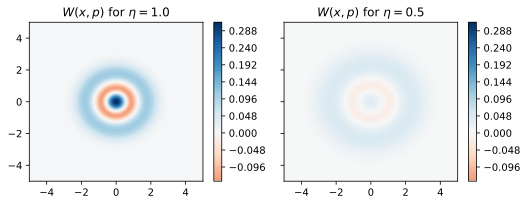

In [14]:
sc1 = np.max(Wp)
W = wigner(Qobj(rho/np.trace(rho)), xvec, xvec)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3),sharey=True)
axes[0].contourf(xvec, xvec, Wp, 60,cmap=cm.RdBu, norm=nrm)
axes[0].contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes[0].set_title(r"$W(x,p)$ for $\eta = 1.0$");
cb1 = fig.colorbar(plt1, ax=axes[0])
plt2 = axes[1].contourf(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
plt2 = axes[1].contour(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
axes[1].set_title(r"$W(x,p)$ for $\eta = 0.5$");
cb2 = fig.colorbar(plt1, ax=axes[1])
fig.tight_layout()
plt.show()

and also a cut of the Wigner function along $x=0$

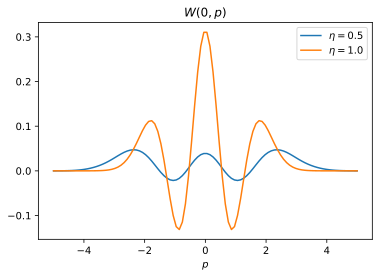

In [15]:
plt.plot(xvec, W[:,grid//2], label=r"$\eta=0.5$")
plt.plot(xvec, Wp[:,grid//2], label=r"$\eta=1.0$")
plt.title(r"$W(0,p)$")
plt.xlabel(r"$p$")
plt.legend()
plt.show()

In [16]:
%reload_ext version_information
%version_information qutip, strawberryfields, thewalrus

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.2.0
OS Linux 4.15.0 65 generic x86_64 with debian stretch sid
qutip 4.3.1
strawberryfields 0.12.0-dev
thewalrus 0.10.0-dev
Wed Nov 13 11:50:21 2019 EST